# Final Project: League of Legends Match Predictor
## Logistic Regression using PyTorch




In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)

# Create synthetic League of Legends match data
data = {
    "kills": np.random.randint(0, 30, 500),
    "deaths": np.random.randint(0, 30, 500),
    "assists": np.random.randint(0, 40, 500),
    "gold_earned": np.random.randint(5000, 20000, 500),
    "damage_dealt": np.random.randint(10000, 60000, 500),
    "wards_placed": np.random.randint(0, 50, 500),
    "win": np.random.randint(0, 2, 500)  # target variable
}

df = pd.DataFrame(data)

# Save dataset
df.to_csv("league_of_legends_data.csv", index=False)

df.head()


,kills,deaths,assists,gold_earned,damage_dealt,wards_placed,win
0,6,9,16,16622,54064,13,0
1,19,22,20,12368,17813,3,1
2,28,25,13,10877,41598,47,1
3,14,2,8,6301,57182,45,0
4,10,17,0,7541,37570,26,0


In [3]:
df = pd.read_csv("league_of_legends_data.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   kills         500 non-null    int64
 1   deaths        500 non-null    int64
 2   assists       500 non-null    int64
 3   gold_earned   500 non-null    int64
 4   damage_dealt  500 non-null    int64
 5   wards_placed  500 non-null    int64
 6   win           500 non-null    int64
dtypes: int64(7)
memory usage: 27.5 KB


In [4]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop("win", axis=1)
y = df["win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1,1)


In [5]:
import torch.nn as nn

class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))


In [6]:
import torch.optim as optim

model = LogisticRegressionModel(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

print("Training complete")


Training complete


In [7]:
from sklearn.metrics import accuracy_score

with torch.no_grad():
    y_pred_prob = model(X_test)
    y_pred = (y_pred_prob >= 0.5).float()

accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Test Accuracy: 0.52


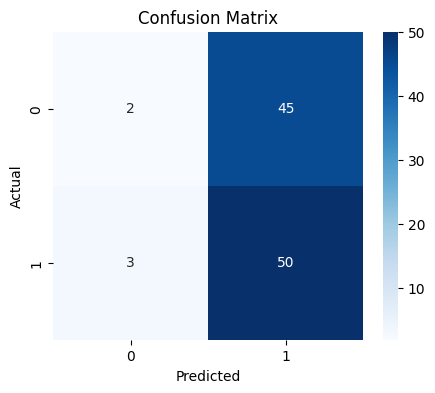

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


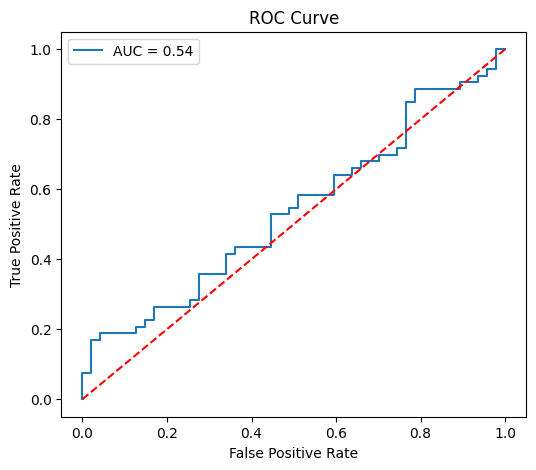

In [9]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test.numpy(), y_pred_prob.numpy())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [10]:
# Save model
torch.save(model.state_dict(), "lol_logistic_model.pth")

# Load model
loaded_model = LogisticRegressionModel(X_train.shape[1])
loaded_model.load_state_dict(torch.load("lol_logistic_model.pth"))
loaded_model.eval()

print("Model saved and loaded successfully")


Model saved and loaded successfully


In [11]:
learning_rates = [0.001, 0.005, 0.01, 0.05]
best_accuracy = 0
best_lr = None

for lr in learning_rates:
    temp_model = LogisticRegressionModel(X_train.shape[1])
    optimizer = optim.Adam(temp_model.parameters(), lr=lr)

    for epoch in range(50):
        optimizer.zero_grad()
        output = temp_model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        preds = (temp_model(X_test) >= 0.5).float()
        acc = accuracy_score(y_test, preds)

    print(f"Learning Rate: {lr}, Test Accuracy: {acc}")

    if acc > best_accuracy:
        best_accuracy = acc
        best_lr = lr

print("Best Learning Rate:", best_lr)
print("Best Test Accuracy:", best_accuracy)


Learning Rate: 0.001, Test Accuracy: 0.38
Learning Rate: 0.005, Test Accuracy: 0.49
Learning Rate: 0.01, Test Accuracy: 0.51
Learning Rate: 0.05, Test Accuracy: 0.55
Best Learning Rate: 0.05
Best Test Accuracy: 0.55


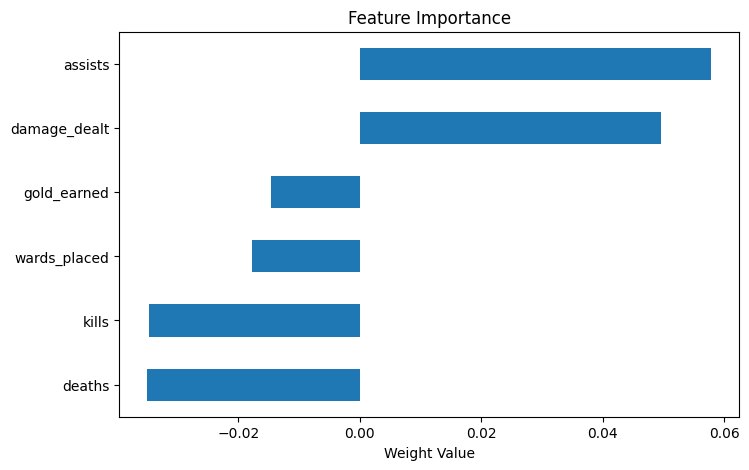

Top 3 Most Important Features:
assists         0.057817
damage_dealt    0.049575
deaths          0.034978
dtype: float32


In [12]:
import pandas as pd

weights = model.linear.weight.detach().numpy()[0]
feature_importance = pd.Series(weights, index=X.columns)

plt.figure(figsize=(8,5))
feature_importance.sort_values().plot(kind="barh")
plt.title("Feature Importance")
plt.xlabel("Weight Value")
plt.show()

print("Top 3 Most Important Features:")
print(feature_importance.abs().sort_values(ascending=False).head(3))
